## Learning a model

In [45]:
%matplotlib inline
import numpy as np    # used for numerical array - nd-array: very fast
import scipy as sp     # distributions are here
import matplotlib as mpl
import matplotlib.cm as cm  # color maps
import matplotlib.pyplot as plt  # specific plotting library
import pandas as pd             
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns    # brings many plots into mpl, and looks better
sns.set_style("whitegrid")
sns.set_context("paper")    # images small

In [46]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(15,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

###A simple model

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.


In [47]:
x = np.arange(0,1, 0.01)

In [48]:
morex=sp.stats.norm.rvs(loc=0.7, scale=0.1, size=100)
morex = morex - (morex > 1.0)*(morex - 1.0)

Let us assume that we have a "population" of 200 counties $x$:

In [49]:
x = np.sort(np.concatenate((x, morex), axis=1))

Lets suppose now that the Lord came by and told us that the curve in black in the left plot below captures $f(x)$ exactly. The cell below has the values of f at the 200 x points which constitute our "population"; these are also marked in red on the left plot.

In [50]:
f = sp.stats.norm.cdf(x, loc=0.5, scale=0.3)

Notice that our sampling of $x$ is not quite uniform: there are more points around $x$ of 0.7.

Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [51]:
#allindexes=np.sort(np.random.choice(x.shape[0], size=100, replace=False))
indexes=np.sort(np.random.choice(x.shape[0], size=30, replace=False))

In [52]:
samplex = x[indexes]
samplef = f[indexes]

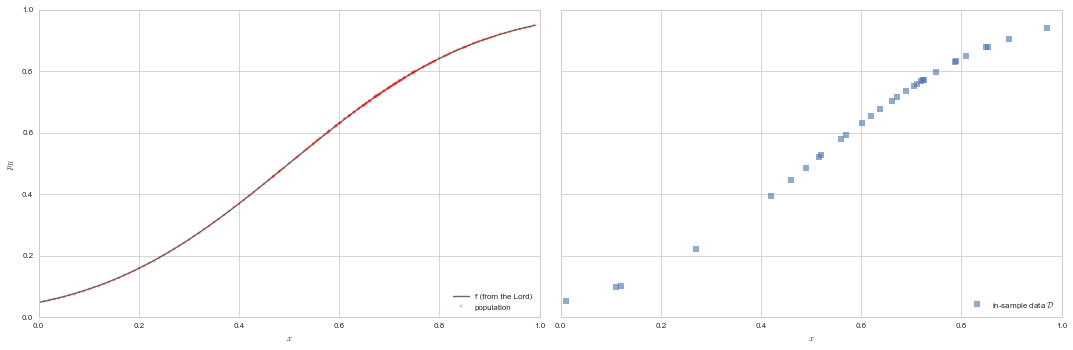

In [53]:
axes=make_plot()
axes[0].plot(x,f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(x,f, 'r.', alpha=0.3, label="population");
axes[1].plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

The lightly shaded squares in the right panel plot are the in-sample $\cal{D}$ of 30 points given to us. Let us then pretend that we have forgotten the curve that the Lord gave us. Thus, all we know is what is on the plot on the right, and we have no clue about what the original curve was, nor do we remember the original "population".

That is, imagine the Lord gave us $f$ but then also gave us amnesia. Remember that such amnesia is the general case in learning, where we *do not know* the target function, but rather just have some data. Thus what we will be doing is *trying to find functions that might have generated the 30 points of data that we can see* in the hope that one of these functions might approximate $f$ well, and provide us a **predictive model** for future data. This is known as **fitting** the data.

###The Hypothesis or Model Space

Such a function, one that we use to fit the data, is called a **hypothesis**. We'll use the notation $h$ to denote a hypothesis. Lets consider as hypotheses for the data above, a particular class of functions called polynomials. 

A polynomial is a function that combines multiple powers of x linearly.  You've probably seen these in school, when working with quadratic or cubic equations and functions:

\begin{align*}
h(x) &=& 9x - 7 && \,(straight\, line) \\
h(x) &=& 4x^2 + 3x + 2 && \,(quadratic) \\
h(x) &=& 5x^3 - 31x^2 + 3x  && \,(cubic).
\end{align*}

In general, a polynomial can be written thus:

\begin{eqnarray*}
 h(x) &=& a_0 + a_1 x^1 + a_2 x^2 + ... + a_n x^n \\
      &=& \sum_{i=0}^{n} a_i x^i
\end{eqnarray*}

Thus, by linearly we mean a sum of coefficients $a_i$ times powers of $x$, $x^i$. In other words, the polynomial is **linear in its coefficients**.

Let us consider as the function we used to fit the data, a hypothesis $h$ that is a straight line. We put the subscript $1$ on the $h$ to indicate that we are fitting the data with a polynomial of order 1, or a straight line. This looks like:

$$ h_1(x) = a_0 + a_1 x $$

We'll call the **best fit** straight line the function $g_1(x)$. The "best fit" idea is this: amongst the set of all lines (i.e., all possible choices of $h_1(x)$), what is the best line $g_1(x)$ that represents the in-sample data we have? (The subscript $1$ on $g$ is chosen to indicate the best fit polynomial of degree 1, ie the line amongst lines that fits the data best).

The best fit $g_1(x)$ is calculated and shown in the figure below:

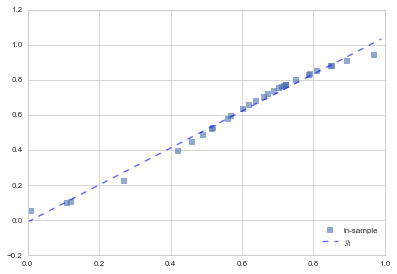

In [54]:
g1 = np.poly1d(np.polyfit(x[indexes],f[indexes],1))
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g1(x), 'b--', alpha=0.6, label="$g_1$");
plt.legend(loc=4);

How did we calculate the best fit. We'll come to that in a bit, but in the meanwhile, lets formalize and generalize the notion of "best fit line amongst lines" a bit.

The set of all functions of a particular kind that we could have used to fit the data is called a **Hypothesis Space**. The words "particular kind" are deliberately vague: its our choice as to what we might want to put into a hypothesis space. A hypothesis space is denoted by the notation $\cal{H}$.

Lets consider the hypothesis space of all straight lines $h_1(x)$. We'll denote it as $\cal{H}_1$, with the subscript being used to mark the order of the polynomial. Another such space might be $\cal{H}_2$, the hypothesis space of all quadratic functions. A third such space might combine both of these together.

In this set-up, what we have done in the code and plot above is this: we have found the best $g_1$ to the data $\cal{D}$ from the functions in the hypothesis space $\cal{H}_1$. This is not the best fit from all possible functions, but rather, the best fit from the set of all the straight lines. 

The hypothesis space here as a concept that captures the **complexity** of a model you use to fit data. For example, since quadratics are more complex functions than straight lines (they curve more), $\cal{H}_2$ is more complex than $\cal{H}_1$. 

In this case, suffering from amnesia about the real model, we decided to use the simplest hypothesis space that gives us some indication of the *trend* of our data: the set of straight lines.

####Deterministic Error or Bias

Notice from the figure above that models in $\cal{H}_1$, i.e., straight lines, and the best-fit straight line $g_1$ in particular, do not do a very good job of capturing the curve of  the data (and thus the underlying function $f$ that we are trying to approximate. Consider the more general case in the figure below, where a curvy $f$ is approximated by a function $g$ which just does not have the wiggling that $f$ has. 

![Bias](https://dl.dropboxusercontent.com/u/75194/images/bias.png)

There is always going to be an error then, in approximating $f$ by $g$. This *approximation error* is shown in the figure by the blue shaded region, and its called **bias**, or **deterministic error**. 

Going back to our model at hand, it is clear that the space of straight lines $\cal{H}_1$ does not capture the curving in the data. So let us consider the more complex hypothesis space $\cal{H}_{10}$, the set of all 10th order polynomials $h_{10}(x)$:

$$h_{10}(x) = \sum_{i=0}^{10} a_i x^i\,.$$

A 10th order polynomial can give quite different behaviour, as we can see below, by constructing a few 10th order polynomials, 2 with random, and one with largish coefficients:

In [55]:
#5.0E+13x10 - 2.785E+14x9 + 6.7628E+14x8 - 9.386589E+14x7 + 8.202500265E+14x6 - 
#4.68400976025E+14x5 + 1.75536838952E+14x4 - 4.21755298122E+13x3 + 
#6.13422223352E+12x2 - 480187678425x + 15249527748
polycoeffs=[  2.35615384e+06,  -1.56483136e+07,   4.59659275e+07,
        -7.84930454e+07,   8.60901472e+07,  -6.31811703e+07,
         3.12980410e+07,  -1.02766149e+07,   2.12279116e+06,
        -2.45709407e+05,   1.17944115e+04]

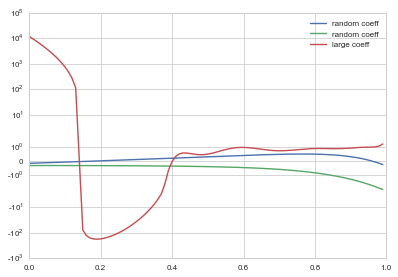

In [56]:
p1=np.poly1d(2*np.random.rand(11)-1)
p2=np.poly1d(2*np.random.rand(11)-1)
p3=np.poly1d(polycoeffs)
plt.plot(x, p1(x), label="random coeff");
plt.plot(x, p2(x), label="random coeff");
plt.plot(x, p3(x), label="large coeff");
plt.yscale("symlog", linthreshx=1e-10)
plt.legend();

Notice the huge range of values the 10th order polynomial with large coefficients takes.

To see how a more complex hypothesis space does, lets find the best fit 20th order polynomial $g_{20}(x)$.


In [57]:
g20 = np.poly1d(np.polyfit(x[indexes],f[indexes],20))
g10 = np.poly1d(np.polyfit(x[indexes],f[indexes],10))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


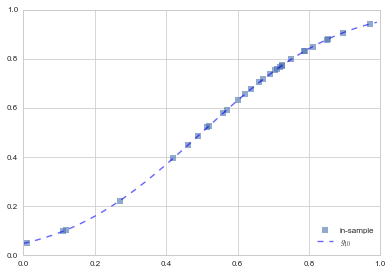

In [58]:
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g10(x), 'b--', alpha=0.6, label="$g_{10}$");
plt.legend(loc=4);

Voila! You can see the 20th order polynomial does a much better job of tracking the points, because of the wiggle room it has in making a curve "go near or through" all the pointsas opposed to a straight line, which well, cant curve. Thus it would seem that $\cal{H}_{10}$ might be a better candidate hypothesis set from which to choose a best fit model. 

We can quantify this by calculating some notion of the bias for both $g_1$ and $g_10$. 
To do this we calculate the square of the difference between f and the g's on the population of 200 points i.e.:

$$B_1(x) = (g_1(x) - f(x))^2 \,;\,\, B_{10}(x) = (g_1(x) - f(x))^2\,.$$ 

Squaring makes sure that we are calculating a positive quantity.

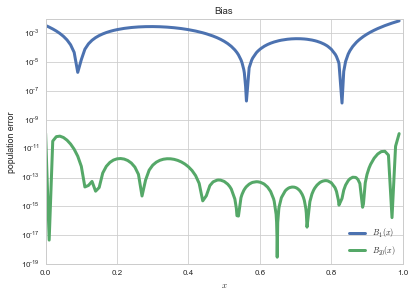

In [59]:
plt.plot(x, (g1(x)-f)**2, lw=3, label="$B_1(x)$")
plt.plot(x, (g10(x)-f)**2, lw=3,label="$B_{20}(x)$");
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.title("Bias");

As you can see the bias or approximation error is much smaller for $g_{20}$.

Is $g_{20}$ the best model for this data from all possible models? Indeed, how do we find the best fit model from the best hypothesis space? This is what **learning** is all about.

We have used the python function `np.polyfit` to find $g_{1}$ the best fit model in $\cal{H}_{1}$ and $g_{20}$ the best fit model in $\cal{H}_{20}$, but how did we arrive at that conclusion? This is the subject of the next section. 

###How to learn the best fit model in a hypothesis space

Let's understand in an intuitive sense, what it means for a function to be a good fit to the data. Lets consider, for now, only the hypothesis space $\cal{H}_{1}$, the set of all straight lines. In the figure below, we draw against the data points (in red) one such line $h_1(x)$ (in red).

![Cost](https://dl.dropboxusercontent.com/u/75194/images/linreg.png)

The natural way of thinking about a "best fit" would be to minimize the distance from the line to the points, for some notion of distance. In the diagram we depict one such notion of distance: the vertical distance from the points to the line. These distances are represented as thin black lines.

The next question that then arises is this: how exactly we define the measure of this vertical distance? We cant take the measure of distance to be the y-value of the point minus the y value of the line at the same x, ie $y_i - h_1(x_i)$. Why? If we did this, then we could have points very far from the line, and as long as the total distance above was equal to the total distance below the line, we'd get a net distance of 0 even when the line is very far from the points. Thus we must use a positive estimate of the distance as our measure. We could take either the absolute value of the distance, $\vert y_i - h_1(x_i) \vert$, or the square of the distance as our measure, $(y_i - h_1(x_i))^2$.

We sum this measure up over all our data points, to create whats known as the **error functional** or **risk functional** of using line $h_1(x)$ to fit our points $y_i \in \cal{D}$ (this notation is to be read as "$y_i$ in $\cal{D}$") :

$$ R_{\cal{D}}(h_i(x)) = \frac{1}{N} \sum_{y_i \in \cal{D}} (y_i - h_1(x_i))^2 $$

where $N$ is the number of points in $\cal{D}$.

What this formula says is: the cost or risk is just the total squared distance to the line from the observation points. Here we use the word **functional** to denote that, just as in functional programming, the risk is a *function of the function* $h_1(x)$. 

We also make explicit the in-sample data $\cal{D}$, because the value of the risk depends upon the points at which we made our observation. If we had made these observations $y_i$ at a different set of $x_i$, the value of the risk would be somewhat different. The hope in learning is that the risk will not be too different, as we shall see in the next section

Now, given these observations, and the hypothesis space $\cal{H}_1$, we minimize the risk over all possible functions in the hypothesis space to find the **best fit** function $g_1(x)$:

$$ g_1(x) = \arg\min_{h_1(x) \in \cal{H}} R_{\cal{D}}(h_1(x)).$$

Here the notation 

$"\arg\min_{x} F(x)"$ 

means: give me the argument of the functional $x$ at which $F(x)$ is minmized. So, for us: give me the function $g_1(x) = h_1$ at which the risk $R_{\cal{D}}(h_1)$ is minimized; i.e. the minimization is over *functions* $h_1$.

(We'll worry about how to actually do this minimization later, currently we are just interested in the conceptual notions).

And this is exactly what the python function `np.polyfit(x,h,n)` does for us. It minimizes this squared-error with respect to the coefficients of the polynomial.

Thus we can in general write:

$$ g(x) = \arg\min_{h(x) \in \cal{H}} R_{\cal{D}}(h(x)),$$

where $\cal{H}$ is a general hypothesis space of functions.

###The structure of learning

Let's illustrate this above process of learning models with a diagram, in a bit more depth, so that we can get to the core of the learning problem. We shall use the figure below, which I adopted from Yasser Abu-Mustafa's excellent book on machine learning. (http://amlbook.com)

![Basic Learning](https://dl.dropboxusercontent.com/u/75194/images/BasicModel.png)

We have a target function $f(x)$ that we do not know. But we do have a sample of data points from it, $(x_1,y_1), (x_2,y_2), ..., (x_n,y_n)$. We call this the **sample** or **training examples** $\cal{D}$. We are interested in using this sample to estimate a function $g$ to approximate the function $f$, and which can be used for prediction at new data points, or on the entire population, also called **out-of-sample prediction**. 

To do this, we use an algorithm, called the **learner**, which chooses functions from a hypothesis set $\cal{H}$ and computes a cost measure or risk functional $R$ (like the sum of the squared distance over all points in the data set) for each of these functions. It then chooses the function $g$ which **minimizes** this cost measure amonst all the functions in $\cal{H}, and gives us a final hypothesis $g$ which we then use to approximate or estimate f **everywhere**, not just at the points in our data set. 

Here our learner is called Polynomial **Regression**, and it takes a hypothesis space $\cal{H}_d$ of degree $d$ polynomials, minimizes the "squared-error" risk measure, and spits out a best-fit hypothesis $g_d$.


#### Empirical Risk Minimization

We write $g \approx f$, or $g$ is the **estimand** of $f$. This process is called **Empirical Risk Minimization** (ERM) as we minimize the cost measure over the "empirically observed" training examples or points.

Why do we think that this might be a good idea? What are we really after?

What we'd like to do is **make good predictions**. In the language of cost, what we are really after is to minimize the cost **out-of-sample**, on the population at large. But this presents us with a conundrum: how can we minimize the risk on points we havent yet seen?

This is why we (a) minimize the risk on the set of points that we have, or do ERM to find $g$ and then (b) hope that once we have found our best model $g$, our risk does not particularly change out-of-sample, or when using a different set of points

In a sense, this is our old issue: we are once again drawing conclusions about a population from a sample. (The only difference here is that we have both data covariates or features $x_i$ as well as data points $y_i$.

#### The role of sampling

Intuitively, to do this, we need to ask ourselves, how representative is our sample? Or more precisely, how representative is our sample of our training points of the population (or for that matter the new x that we want to predict for)? 

We illustrate this below for our population of 200 data points and our sample of 30 data points (in red).

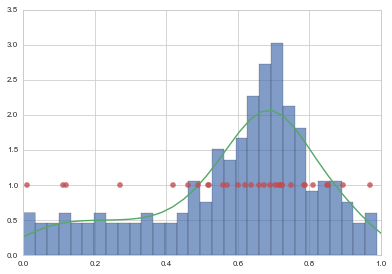

In [60]:
plt.hist(x, normed=True, bins=30, alpha=0.7)
sns.kdeplot(x)
plt.plot(x[indexes], [1.0]*len(indexes),'o', alpha=0.8)
plt.xlim([0,1]);

In our example, if we only want to use $g$, our estimand of $f$ to predict for large $x$, or more religious counties, we would need a good sampling of points $x$ closer to 1. And, similarly, the new $x$ we are using to make predictions would also need to be representative of those counties. We wont do well if we try and predict low-religiousness counties from a sample of high-religiousness ones. Or, if we do want to predict over the entire range of religiousness, our training sample better cover all $x$ well.

This is why, in the diagram above, we introduce the "input" probability distribution $P(x)$, and draw lines from it to both our sample set and our final hypothesis. We thus indicate that both the training set that we use to estimate $g$ from, and the population that we want to predict on must be drawn from the same distribution. 

#### Statement of the learning problem.

Once we have done that, we can then intuitively say that, if we find a hypothesis $g$ that minimizes the cost or risk over the training set; this hypothesis *might* do a good job over the population that the training set was representative of, since the risk on the population ought to be similar to that on the training set, and thus small.

Mathematically, we are saying that:

\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out \,of \,sample} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}


In other words, we hope the **empirical risk estimates the out of sample risk well, and thus the out of sample risk is also small**.

Indeed, as we can see below, $g_{20}$ does an excellent job on the population, not just on the sample.

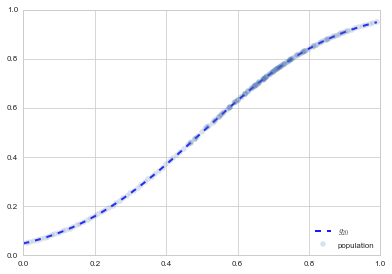

In [61]:
#plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g20(x), 'b--', alpha=0.9, lw=2, label="$g_{20}$");
plt.plot(x,f, 'o', alpha=0.2, label="population");
plt.legend(loc=4);

###Noise

You probably noticed that I used weasel words like "might" and "hope" in the last section when saying that representative sampling in both training and test sets combined with ERM is what we need to learn a model. Let me give you a very simple counterexample: a prefect memorizer.

Suppose I construct a model which memorizes all the data points in the training set. Then its emprical risk is zero by definition, but it has no way of predicting anything on a test set. Thus it might as well choose the value at a new point randomly, and will perform very poorly. The process of interpolating a curve from points is precisely this memorization


We saw in the diagram above that $g_20$ did a very good job in capturing the curves of the population. However, note that the data obtained from $f$, our target, was still quite smooth. Most real-world data sets are not smooth at all, because of various effects such as measurement errors, other co-variates, and so on. Such **stochastic noise** plays havoc with our fits, as we shall see soon.

####Stochastic Noise, or the problem with randomness.

Stochastic noise bedevils almost every data set known to humans, and happens for many different reasons. 

Consider for example two customers of a bank with identical credit histories and salaries. One defaults on their mortgage, and the other does not. In this case we have identical $x = (credit, salary)$ for these two customers, but different $y$, which is a variable that is 1 if the customer defaulted and 0 otherwise. The true $y$ here might be a function of other co-variates, such as marital strife, sickness of parents, etc. But, as the bank, we might not have this information. So we get different $y$ for different customers at the information $x$ that we possess.

A similar thing might be happen in the election example, where we have modelled the probability of voting for romney as a function of religiousness of the county. There are many other variables we might not have measured, such as the majority race in that county.  But, we have not measured this information. Thus, in counties with high religiousness fraction $x$ we might have more noise than in others. Consider for example two counties, one with $x=0.8$ fraction of self-identified religious people in the county, and another with $x=0.82$. Based on historical trends, if the first county was mostly white, the fraction of those claiming they would vote for Romney might be larger than in a second, mostly black county. Thus you might have two very $y$'s next to each other on our graphs.

It gets worse. When pollsters estimate the number of people voting for a particular candidate, they only use finite samples of voters. So there is a 4-6\% polling error in any of these estimates. This "sampling noise" adds to the noisiness of the $y$'s.

Such errors typically come in both positive and negative around an average value of 0, and can be dealt with statistically. The usual way to do this is to imagine that the errors follow a bell curve or normal distribution with mean at 0.

In [62]:
sigma=0.06
mask=(x > 0.65) & (x < 0.8)
sigmalist=sigma+mask*0.03

In [63]:
y = f + sp.stats.norm.rvs(scale=sigmalist, size=200)
#the next three lines just ensure that y remains a probability
yadd = (y < 0.0) *(0.01-y)
ysub = (y > 1.0)*(y - 1.0)
y = y + yadd -ysub

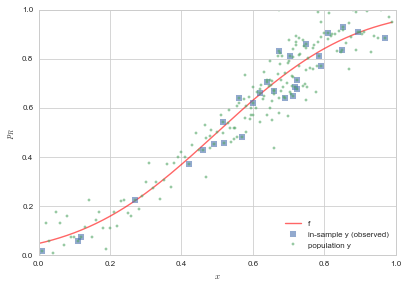

In [64]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.6, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.6, label="population y");
plt.xlabel('$x$');
plt.ylabel('$p_R$')
plt.legend(loc=4);

In the figure above, one can see the scatter of the $y$ population about the curve of $f$. The errors of the 30 observation points ("in-sample") are shown as squares. One can see that observations next to each other can now be fairly different, as we descibed above.


###Fitting a noisy model: the complexity of your hypothesis

Let us now try and fit the noisy data we simulated above, both using straight lines ($\cal{H}_1$), and 20th order polynomials($\cal{H}_{20}$). We update out learning diagram with just one change below: 
![Noisy Learning](https://dl.dropboxusercontent.com/u/75194/images/bookimages/NoisyModelPxy.png)

The change is the introduction of a noisy target $y$, so that

$$y = f(x) + \epsilon\,,$$

where $\epsilon$ is a noise term that represents the stochastic noise. In the simulation of errors above we assumed that $\epsilon$ came from a bell curve. Note that this means that $\epsilon$ will be different at different $x$, with its values chosen from a bell curve.

Another way to think about a noisy $y$ is to imagine that we now have a joint probability distribution $P(x,y)$, as shown in the diagram. In our earlier case with no stochastic noise, once you new $x$, if I were to give you $f(x)$, you could give me $y$. This is now not possible because of the noise $\epsilon$: we dont know exactly how much we have. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, as well using a probability distribution (a bell curve in our example). Since P(x) is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x) .$$

Its worth pointing out that the entire learning problem can be cast as a problem in probability **density estimation**: if we can estimate $P(x,y)$ and take actions based on that estimate thanks to our risk or error functional, we are done. 

We now fit in both $\cal{H}_1$ and $\cal{H}_{20}$ to find the best fit straight line and best fit 20th order polynomial respectively.

In [65]:
g1noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],1))
g20noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],20))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


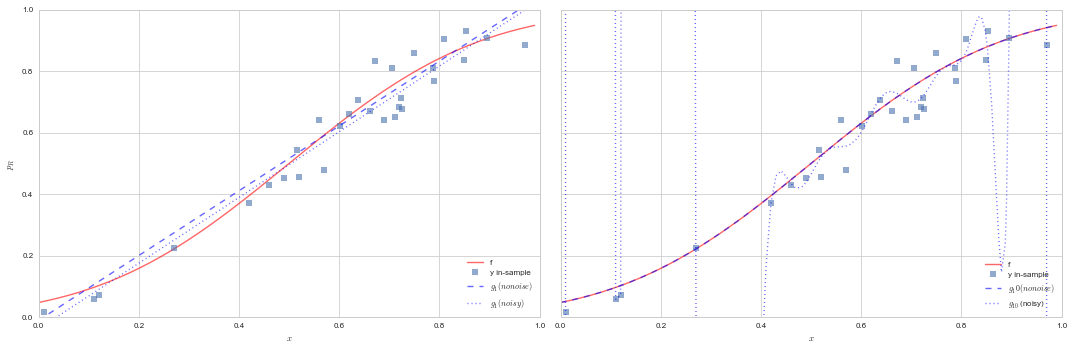

In [66]:
axes=make_plot()
axes[0].plot(x,f, 'r-', alpha=0.6, label="f");
axes[1].plot(x,f, 'r-', alpha=0.6, label="f");
axes[0].plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
axes[1].plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
axes[0].plot(x,g1(x),  'b--', alpha=0.6, label="$g_1 (no noise)$");
axes[0].plot(x,g1noisy(x), 'b:', alpha=0.6, label="$g_1 (noisy)$");
axes[1].plot(x,g20(x),  'b--', alpha=0.6, label="$g_10 (no noise)$");
axes[1].plot(x,g20noisy(x), 'b:', alpha=0.6, label="$g_{10}$ (noisy)");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

The results are (to put it mildly) very interesting. 

Lets look at the figure on the left first. The noise changes the best fit line by a little but not by much. The best fit line still does a very poor job of capturing the variation in the data.

The best fit 10th order polynomial, in the presence of noise, is very interesting. It tries to follow all the curves of the observations..in other words, it tries to fit the noise. This is a disaster, as you can see if you plot the population (out-of-sample) points on the plot as well:

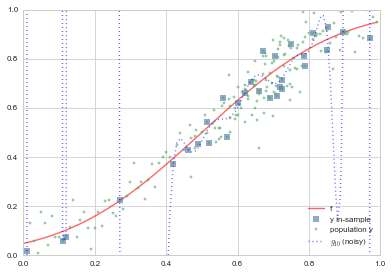

In [67]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
plt.plot(x,y,  '.', alpha=0.6, label="population y");
plt.plot(x,g20noisy(x), 'b:', alpha=0.6, label="$g_{10}$ (noisy)");
plt.ylim([0,1])
plt.legend(loc=4);

Whoa. The best-fit 20th order polynomial does a reasonable job fitting the in-sample data, and is even well behaved in the middle where we have a lot of in-sample data points. But at places with less in-sample data points, the polynomial wiggles maniacally.

This fitting to the noise is a danger you will encounter again and again in learning. Its called **overfitting**. So, $\cal{H}_{20}$ which seemed to be such a good candidate hypothesis space in the absence of noise, ceases to be one. The take away lesson from this is that we must further ensure that our **model does not fit the noise**.

Lets make a plot similar to the one we made for the deterministic noise earlier, and compare the error in the new $g_1$ and $g_20$ fits on the noisy data.

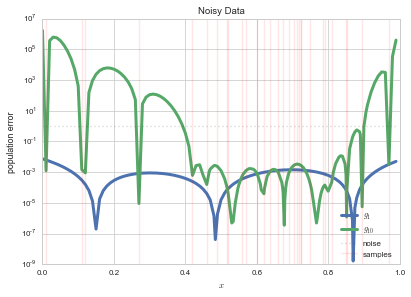

In [68]:
plt.plot(x, ((g1noisy(x)-f)**2), lw=3, label="$g_1$")
plt.plot(x, ((g20noisy(x)-f)**2), lw=3,label="$g_{10}$");
plt.plot(x, [1]*x.shape[0], "k:", label="noise", alpha=0.2);
for i in indexes[:-1]:
    plt.axvline(x[i], 0, 1, color='r', alpha=0.1)
plt.axvline(x[indexes[-1]], 0, 1, color='r', alpha=0.1, label="samples")
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.title("Noisy Data");

$g_1$ now, for the most part, has a lower error! So you'd be better off by having chosen a set of models with much more bias (the straight lines, $\cal{H}_1$) than a more complex model set ($\cal{H}_{20}$) in the case of noisy data. 

###The Variance of your model

This tendency of a more complex model to overfit, by having enough freedom to fit the noise, is described by something called high **variance**. What is variance?

Variance, simply put, is the "error-bar" or spread in models that would be learnt by training on different data sets $\cal{D}_1, \cal{D}_2,...$ drawn from the population. Now, this seems like a circular concept, as in real-life, you do not have access to the population. But since we simulated our data here anyways, we do, and so let us see what happens if we choose different 30 points randomly from our population of 200, and fit models in both $\cal{H}_1$ and $\cal{H}_{20}$ to them. We do this on 200 sets of randomly chosen (from the population) data sets of 30 points each and plot the best fit models in noth hypothesis spaces for all 200 sets.

In [69]:
def gen(degree, nsims, size, x, out):
    outpoly=[]
    for i in range(nsims):
        indexes=np.sort(np.random.choice(x.shape[0], size=size, replace=False))
        pc=np.polyfit(x[indexes], out[indexes], degree)
        p=np.poly1d(pc)
        outpoly.append(p)
    return outpoly

In [70]:
polys1 = gen(1, 200, 30,x, y);
polys20 = gen(20, 200, 30,x, y);

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python

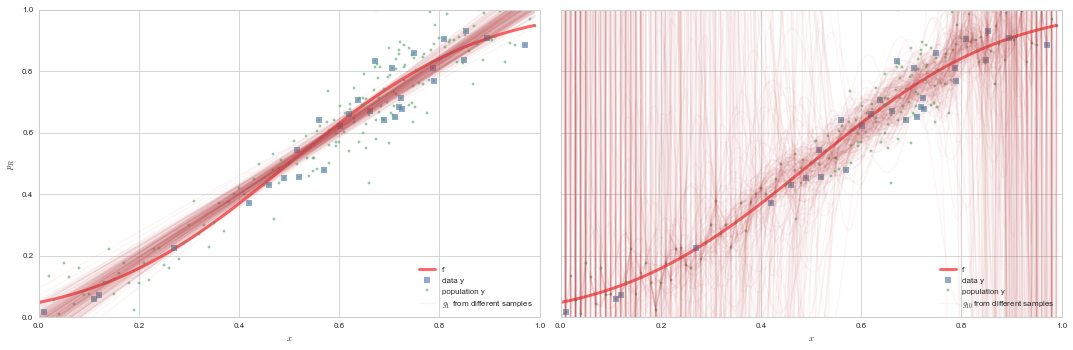

In [71]:
axes=make_plot()
axes[0].plot(x,f, 'r-', lw=3, alpha=0.6, label="f");
axes[1].plot(x,f, 'r-', lw=3, alpha=0.6, label="f");
axes[0].plot(x[indexes], y[indexes], 's', alpha=0.6, label="data y");
axes[1].plot(x[indexes], y[indexes], 's', alpha=0.6, label="data y");
axes[0].plot(x, y, '.', alpha=0.6, label="population y");
axes[1].plot(x, y, '.', alpha=0.6, label="population y");
c=sns.color_palette()[2]
for i,p in enumerate(polys1[:-1]):
    axes[0].plot(x,p(x), alpha=0.05, c=c)
axes[0].plot(x,polys1[-1](x), alpha=0.05, c=c,label="$g_1$ from different samples")
for i,p in enumerate(polys20[:-1]):
    axes[1].plot(x,p(x), alpha=0.05, c=c)
axes[1].plot(x,polys20[-1](x), alpha=0.05, c=c, label="$g_{10}$ from different samples")
axes[0].legend(loc=4);
axes[1].legend(loc=4);

On the left panel, you see the 200 best fit straight lines, each a fit on a different 30 point training sets from the 200 point population. The best-fit lines bunch together, even if they dont quite capture $f$ (the thick red line) or the data (squares) terribly well.

On the right panel, we see the same with best-fit models chosen from $\cal{H}_{20}$. It is a diaster. While most of the models still band around the central trend of the real curve $f$ and data $y$ (and you still see the waves corresponding to all too wiggly 20th order polynomials), a substantial amount of models veer off into all kinds of noisy hair all over the plot. This is **variance**: the the predictions at any given $x$ are all over the place.

The variance can be seen in a different way by plotting the coefficients of the polynomial fit. Below we plot the coefficients of the fit in $\cal{H}_1$. The variance is barely 0.2 about the mean for both co-efficients.

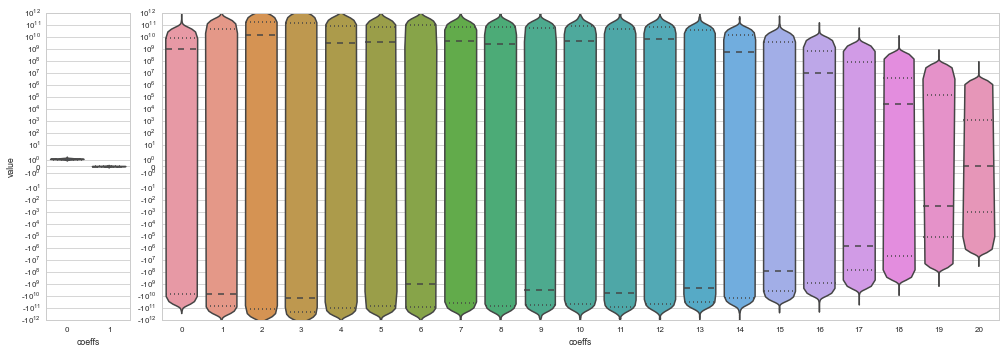

In [72]:
pdict1={}
pdict20={}
for i in reversed(range(2)):
    pdict1[i]=[]
    for j, p in enumerate(polys1):
        pdict1[i].append(p.c[i])
for i in reversed(range(21)):
    pdict20[i]=[]
    for j, p in enumerate(polys20):
        pdict20[i].append(p.c[i]) 
df1=pd.DataFrame(pdict1)
df20=pd.DataFrame(pdict20)
fig = plt.figure(figsize=(14, 5)) 
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 10]) 
axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
axes[0].set_ylabel("value")
axes[0].set_xlabel("coeffs")
axes[1].set_xlabel("coeffs")
plt.tight_layout();
sns.violinplot(df1, ax=axes[0]);
sns.violinplot(df20, ax=axes[1]);
axes[0].set_yscale("symlog");
axes[1].set_yscale("symlog");
axes[0].set_ylim([-1e12, 1e12]);
axes[1].set_ylim([-1e12, 1e12]);

In the right panel we plot the coefficients of the fit in $\cal{H}_{20}$. This is why we use the word "variance": the spread in the values of the middle coefficients about their means (dashed lines) is of the order $10^10$ (the vertical height of the bulges), with huge outliers!! The 20th order polynomial fits are a disaster!

###  The size of the data sample

Why should this be cause for heartburn? Intuitively we know that this is too little data to try and constrain such a complex model well. There is just too little power in the data to be able to fit 20-coefficients tightly. Thus our fits in $\cal{H}_{20}$ are going to be bad. The coefficients will not be well constrained, as we saw above. Indeed, consider the edge case of fitting a 30th order polynomial. We'd then get a polynomial that would interpolate all 30 points. But it would wiggle so much to the noise that it would be a disaster on any new points. And that is ultimately what we want: the ability to predict the function at new points, or out-of-sample, well.

The corollary of this observation is that the more data you have, the more complex a model you can try and fit, and the smaller the chance that you will just be fitting noise.

The fit in $\cal{H}_{1}$ did better as we were much more conservative about the complexity of the polynomial we tried to fit, having only 30 points of data. The critical thing here is, the complexity of the models we choose must be conservative enough for the amount of data we have been given. The **model complexity must match the amount of data, rather than the complexity of $f$, also known as the target complexity**. This is an important and often forgotten point. 


We can demonstrate the effect  of the size of the training set $\cal{D}$ on the fit in a very dramatic way using straight line fits to a sinusoidal curve, as you can see below. We create a poipulation of 200 points from the sine curve. We then choose 5 points randomly, and fit a straight line to them. We repeat this process 200 times, and show the results on the left panel of the figure below.

We repeat the entire process, but this time we choose 2 points at random, 200 times, and draw the straight line joning these 2 points. In the right panel we show the results of this process, and you can see how much hairier and all over the place the lines are.

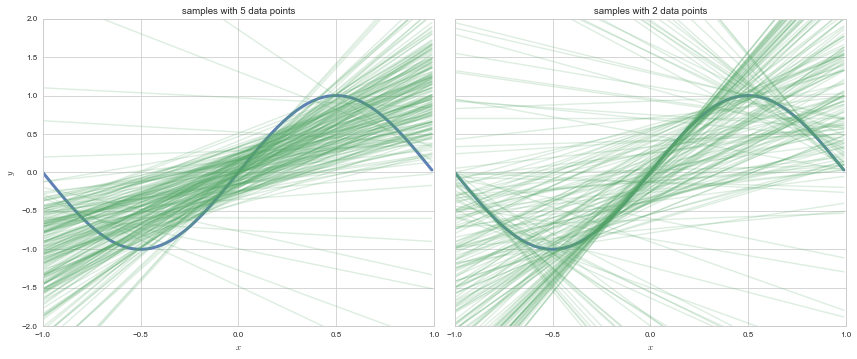

In [73]:
ff = lambda x: np.sin(np.pi*x)
xs=np.arange(-1.,1.,0.01)
ffxs=ff(xs)
E=np.empty((200,5), dtype="int")
for i in range(200):
    E[i,:] = np.random.choice(200, replace=False, size=5)
axes=make_simple_plot()
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
axes[0].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
axes[1].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
for i in range(200):
    choices0 = E[i,:]
    choices1 = np.random.choice(E[i,:], size=2, replace=False)
    p0=np.polyfit(xs[choices0], ffxs[choices0],1)
    p1=np.polyfit(xs[choices1], ffxs[choices1],1)
    axes[0].plot(xs, np.polyval(p0, xs), color=c1, alpha=0.2)
    axes[1].plot(xs, np.polyval(p1, xs), color=c1, alpha=0.2)
axes[0].set_title("samples with 5 data points");
axes[1].set_title("samples with 2 data points");

In [74]:
df=pd.DataFrame({'x':x[indexes], 'f': f[indexes], 'y':y[indexes]})
df.head()

,f,x,y
0,0.051199,0.01,0.015900
1,0.096800,0.11,0.058539
2,0.102637,0.12,0.072802
3,0.221640,0.27,0.224652
4,0.394863,0.42,0.370738


In [75]:
df.to_csv("romneysamples.csv", index=False)